## Encoder-Decoder Interface

In [1]:
import tensorflow as tf

class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, X, *args, **kwargs):
        raise NotImplementedError
        
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, X, *args, **kwargs):
        raise NotImplementedError
        
    def init_state(self, encoder_outputs, *args):
        raise NotImplementedError

In [87]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_x,  *args, **kwargs)
        decoder_state = self.decoder.init_state(enc_outputs, *args)
        
        return self.decoder(dec_X, decoder_state, **kwargs)

## Seq2seq model

### Encoder
At each timestep of encoder $t$,

$$h_t = f(x_t, h_{t-1})$$

Then, the context variable from encoder is
$$c = q(h_1,...,h_T)$$
where $h_t$ is hidden states at timestep $t$ of all layers.

> We'll use $c = q(h_1,...,h_T) = h_T$

In [90]:
class Seq2Seq_Encoder(Encoder):
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        
        self.embed = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embed_size)
        self.rnn   = tf.keras.layers.RNN(
            tf.keras.layers.StackedRNNCells(
                [
                    tf.keras.layers.GRUCell(units = num_hiddens, dropout = dropout)
                    for _ in range(num_layers)
                ]
            ),
            name='Encoder_RNN',
            return_sequences=True,  ## True: return full output sequence, False: return last output sequence
            return_state=True       ## True: return all hidden state
        )
        
    def call(self, X, *args, **kwargs):
        assert tf.rank(X) == 2                    # (batch_size, timesteps)
        emb_vector = self.embed(X)                # (batch_size, timesteps, emb_dim)
        output = self.rnn(emb_vector,  **kwargs)  # (batch_size, timesteps, num_hiddens)
        
        return output[0], output[1:]  
    ## the hidden states of the last layer at all the time steps, 
    ## (for GRU) hidden state of last time step of each layer

### Decoder
$S: $ `(num_encRnn_layers, num_encRnn_hiddens)`  ; All last hidden state from encoder

$C = S[-1] $ : `(1, num_encRnn_hiddens)` ; last hidden state of last layer (according to $q$)

At each timstep of decoder $t^{\prime}$, 

#### 1) Training

$X_{t^{\prime}} = Y_{t^{\prime}-1}$ : `(batch_size, max_steps)`  ; decoder input when training is $Y_{t^{\prime}-1}$ where $X_{t^{\prime} = 0} = \text{<bos>}$

$\text{decoder input} = [\text{embed}(X_{t^{\prime}})  ;  C]$ :  `(batch_size, max_steps, emb_size + C.shape[0])`

$\text{decoder initial state} = S$ : `(num_layers, num_hiddens)` ; the same in both encoder and decoder

___
#### 2) Prediction
$X_{t^{\prime}} = \hat{Y}_{t^{\prime}-1}$ : `(batch_size, 1)`

$\text{decoder input} = [\text{embed}(X_{t^{\prime}}) ; C]$

In [96]:
class Seq2Seq_Decoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embed_size)
        self.rnn   = tf.keras.layers.RNN(
            tf.keras.layers.StackedRNNCells([
                tf.keras.layers.GRUCell(units = num_hiddens, dropout = dropout) 
                for _ in range(num_layers)
            ]),
            name = 'Decoder_RNN',
            return_sequences = True
        )
        self.dense = tf.keras.layers.Dense(units = vocab_size)
        
    def init_state(self, enc_outputs, *args):
        _, last_h_of_EachLayer = enc_outputs
        return last_h_of_EachLayer  # return last-step hidden state of all layer 
        
    def call(self, X, state, **kwargs):  ## X : (batch_size, max_steps) and state : (1, num_encRnn_hiddens)
        X = self.embed(X)  ## X : (batch_size, max_steps, emb_size)
        
        ## construct Decoder input : (batch_size, max_steps, emb_size + last_state.shape[1])
        max_steps = X.shape[1]
        context = tf.repeat(tf.expand_dims(state[-1], axis=1), repeats=max_steps, axis=1)
        dec_input = tf.concat([X, context], axis=2)
        
        ## Forward pass: pass hidden state from rnn to Dense
        rnn_output = self.rnn(inputs=dec_input, initial_state=state)
        output = self.dense(rnn_output)   ## output : (batch_size, vocab_size)
        
        return output

In [74]:
X = tf.zeros((4, 7))
encoder = Seq2Seq_Encoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder = Seq2Seq_Decoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)

state = decoder.init_state(encoder(X))
output = decoder(X, state, training=False)

output.shape

state.len = 2
state.shape = (4, 16)
X.shape = (4, 7)
dec_intput.shape = (4, 7, 24)


TensorShape([4, 7, 10])

### Masked loss function
If pad 0 at the very begining, this step can be skipped.

In [84]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = tf.range(start=0, limit=maxlen, dtype=tf.float32)[
        None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)

    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    else:
        return tf.where(mask, X, value)

X = tf.constant([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]])>

In [85]:
#@save
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """The softmax cross-entropy loss with masks."""
    def __init__(self, valid_len):
        super().__init__(reduction='none')
        self.valid_len = valid_len

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def call(self, label, pred):
        weights = tf.ones_like(label, dtype=tf.float32)
        weights = sequence_mask(weights, self.valid_len)
        
        label_one_hot = tf.one_hot(label, depth=pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none')(label_one_hot, pred)
        weighted_loss = tf.reduce_mean((unweighted_loss*weights), axis=1)
        return weighted_loss

### Training

In [76]:
from d2l import tensorflow as d2l
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [98]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(num_epochs):
        
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = batch
                ## X : (batch_size, max_steps)
                ## Y : (batch_size, len_target)
            
            # prepare <bos> as the first token for every row in this batch
            bos = tf.reshape(
                    tf.constant([tgt_vocab['<bos>']] * Y.shape[0]),
                    shape=(-1, 1)
                    )
            # dec_input(row=1) : [<bos>, Y(row=1)[1], Y(row=1)[2], ..., Y(row=1)[t-1] ]
            dec_input = tf.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            
            with tf.GradientTape() as tape:
                Y_hat = net(X, dec_input, training=True)
                l = MaskedSoftmaxCELoss(Y_valid_len)(Y, Y_hat)
            
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))

        print(f'loss {l}')

loss 0.043, 1375.7 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x000001C14382DE80>


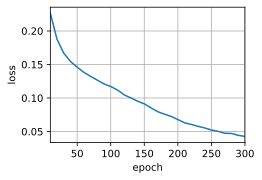

In [99]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

encoder = Seq2Seq_Encoder( len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2Seq_Decoder( len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights=False):
    
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = tf.constant([len(src_tokens)])
    
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = tf.expand_dims(src_tokens, axis=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len, training=False)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state, training=False)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred.numpy())
    return ' '.join(tgt_vocab.to_tokens(tf.reshape(output_seq, shape = -1).numpy().tolist())), attention_weight_seq